### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs, to_numpy

from scipy.spatial import Voronoi
from scipy.spatial import Delaunay

from components.fov_conv2d_cont import FovConv2dCont

# Representations for Phosphene Vision

## Introduction

Phosphene vision enables patients to perceive visual information through patterns of light created by stimulating the retina or visual cortex. The effectiveness of this technology depends heavily on the choice of visual representation, as it determines how well patients can interpret objects, shapes, and scenes.

Using the phosphene simulator from Van Grinten et al., we can simulate how different visual representations are perceived through phosphene vision. This provides an experimental framework to explore how features like spatial frequency, edge detection, and cortical magnification align with the electrode layout and neural responses. By tailoring representations to highlight critical information while minimizing noise, we can optimize the usability of phosphene-based visual prostheses in practical applications.

In [2]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

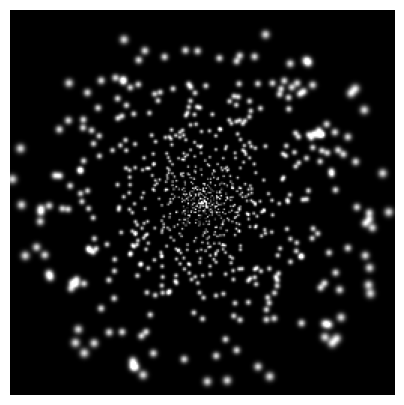

In [3]:
# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

plt.figure(figsize=(5,5))

# Show the phosphene image
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

## Perceived Uniformity and Dynamic Normalization

Phosphene vision often suffers from uneven brightness perception across the visual field. This is primarily due to the variation in electrode density and cortical magnification, which cause phosphenes closer to the center of the field of view to appear brighter than those in the periphery. Achieving perceived uniformity in brightness is critical for creating a consistent and interpretable visual experience for users.

### Algorithm Overview

To address this, we employ an iterative normalization algorithm that adjusts electrode stimulation amplitudes to equalize perceived brightness across the visual field. The algorithm dynamically measures brightness around each electrode, using a patch size that scales with its radial distance from the center of the visual field. This approach ensures that the periphery is measured more generously, accounting for its lower electrode density and reduced sensitivity.

The algorithm works as follows:
1. **Brightness Measurement**: For each electrode, brightness is measured over a patch in the phosphene image. The patch size dynamically increases with radial distance, simulating the effect of cortical magnification.
2. **Target Brightness**: A global target brightness is computed based on the mean brightness of nonzero regions in the image.
3. **Amplitude Adjustment**: Electrode stimulation amplitudes are iteratively updated using a partial learning rule to minimize the deviation from the target brightness. Amplitudes are clamped to predefined minimum and maximum values to ensure stability.

This iterative normalization process allows us to experiment with different simulation parameters, such as patch size scaling and learning rates, and provides a practical method to optimize phosphene brightness for uniformity.


In [4]:
def measure_electrode_brightness_varying(
    phos_image, phos_x, phos_y,
    x_min=-8.0, x_max=8.0,
    y_min=-8.0, y_max=8.0,
    base_size=1,
    scale=0.05,
    center=(0,0)
):
    """
    For each electrode (x_i,y_i), measure brightness in `phos_image` around
    a patch whose size depends on radial distance from `center`.

    Args:
      phos_image : 2D array from the simulator (H,W), can be torch or np
      phos_x, phos_y : arrays of length N
      x_min,x_max,y_min,y_max : bounding coords to map to pixel indices
      base_size : minimal half-size of patch (like 'radius' in pixel terms)
      scale     : how much to increase the patch size per unit distance
      center    : define (cx, cy), the 'center' for radial distance

    Returns:
      brightness : 1D array of length N
    """
    # Convert to numpy if it's torch
    if isinstance(phos_image, torch.Tensor):
        phos_image = phos_image.cpu().numpy()

    H, W = phos_image.shape
    N = len(phos_x)
    brightness = np.zeros(N, dtype=float)

    cx, cy = center

    def to_pixel_coords(x, y):
        px = (x - x_min)/(x_max - x_min)*(W-1)
        py = (y - y_min)/(y_max - y_min)*(H-1)
        return int(round(px)), int(round(py))

    for i in range(N):
        # radial distance from center
        rx = phos_x[i] - cx
        ry = phos_y[i] - cy
        r_i = np.sqrt(rx*rx + ry*ry)

        # dynamic half-size of patch
        half_n = int(round(base_size + scale*r_i))
        # avoid half_n=0 if r_i=0
        half_n = max(half_n, 1)

        px, py = to_pixel_coords(phos_x[i], phos_y[i])

        vals = []
        for dx in range(-half_n, half_n+1):
            for dy in range(-half_n, half_n+1):
                qx = px + dx
                qy = py + dy
                if 0 <= qx < W and 0 <= qy < H:
                    vals.append(phos_image[qy, qx])  # (row, col) => (y, x)

        if len(vals) > 0:
            brightness[i] = np.mean(vals)
        else:
            brightness[i] = 0.0

    return brightness

def iterative_uniform_normalization_varying(
    simulator,
    phos_x, phos_y,
    stim_init,
    steps=5,
    base_size=1,
    scale=0.05,
    center=(0,0),
    A_min=1e-7,
    A_max=1e-3,
    learning_rate=0.5,
    target=None
):
    """
    Iteratively normalizes electrode amplitudes using a varying patch size
    to measure brightness in the outer region more generously.

    We'll reuse the partial update + clamping approach from before.
    """
    stim = stim_init.clone()
    N = len(phos_x)

    for step in range(steps):
        simulator.reset()
        phos_img = simulator(stim)
        # measure brightness with dynamic patch size
        b = measure_electrode_brightness_varying(
            phos_img, phos_x, phos_y,
            x_min=-8.0, x_max=8.0,
            y_min=-8.0, y_max=8.0,
            base_size=base_size,
            scale=scale,
            center=center
        )
        # define target
        if target is None:
            nonzero = b[b>1e-12]
            T = np.mean(nonzero) if len(nonzero)>0 else 1.0
        else:
            T = target

        updated = []
        for i in range(N):
            oldA = stim[i].item()
            meas = b[i]
            if meas < 1e-12:
                # small brightness => partial bump
                newA = oldA*1.1
            else:
                ratio = T/meas
                # partial update
                newA = oldA*(1.0 + learning_rate*(ratio - 1.0))

            # clamp
            if newA < A_min:
                newA = A_min
            elif newA > A_max:
                newA = A_max

            updated.append(newA)

        stim = torch.tensor(updated, device=stim.device, dtype=stim.dtype)

    return stim

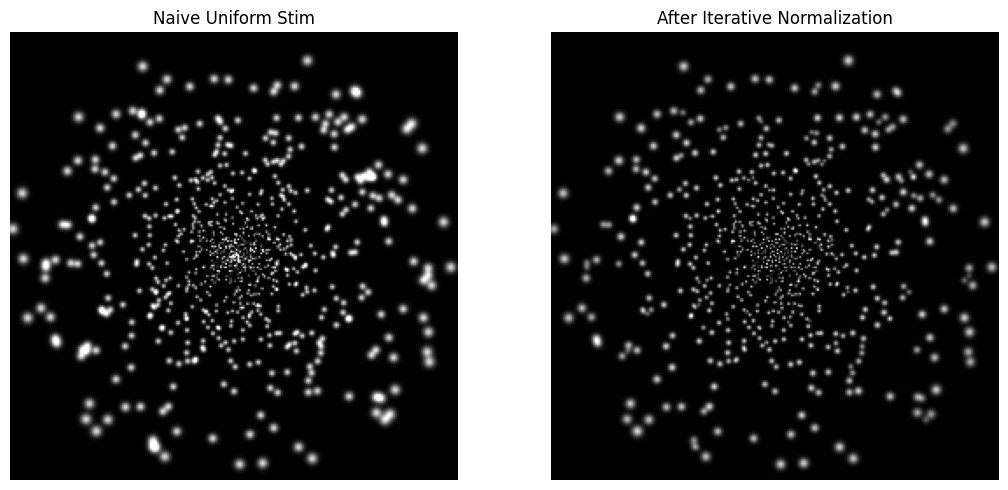

Final amplitude: min=4.37e-05, max=1.60e-04


In [5]:
phos_x = phosphene_coords._x
phos_y = phosphene_coords._y
N = len(phos_x)

stim_uniform = amplitude * torch.ones(N, device='cuda')
simulator.reset()
phos_naive = simulator(stim_uniform)

# iterative approach with dynamic patch
stim_final = iterative_uniform_normalization_varying(
    simulator,
    phos_x, phos_y,
    stim_init=stim_uniform,
    steps=50,
    base_size=1,
    scale=0.5,
    center=(0,0),
    A_min=0,
    A_max=amplitude,
    learning_rate=0.05,
    target=None  # auto-averaging
)

simulator.reset()
phos_final = simulator(stim_final)

plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.title("Naive Uniform Stim")
plt.imshow(phos_naive.cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("After Iterative Normalization")
plt.imshow(phos_final.cpu().numpy(), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Final amplitude: min={stim_final.min():.2e}, max={stim_final.max():.2e}")

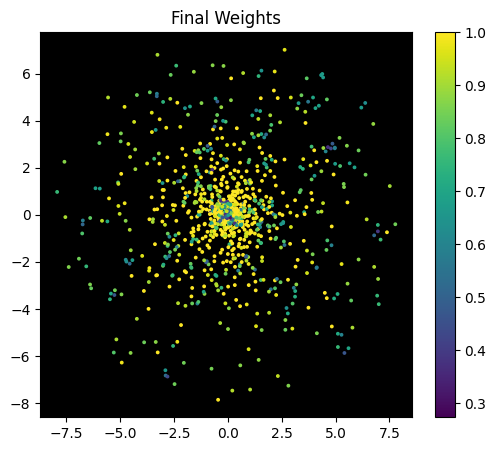

In [6]:
stim_weights = stim_final/amplitude

# show the stim_final values on the phosphene_coords locations
plt.figure(figsize=(6,5))
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=to_numpy(stim_weights), cmap='viridis', s=3)
plt.colorbar()
plt.title("Final Weights")
# black background
plt.gca().set_facecolor('black')
# plt.axis('off')
plt.show()

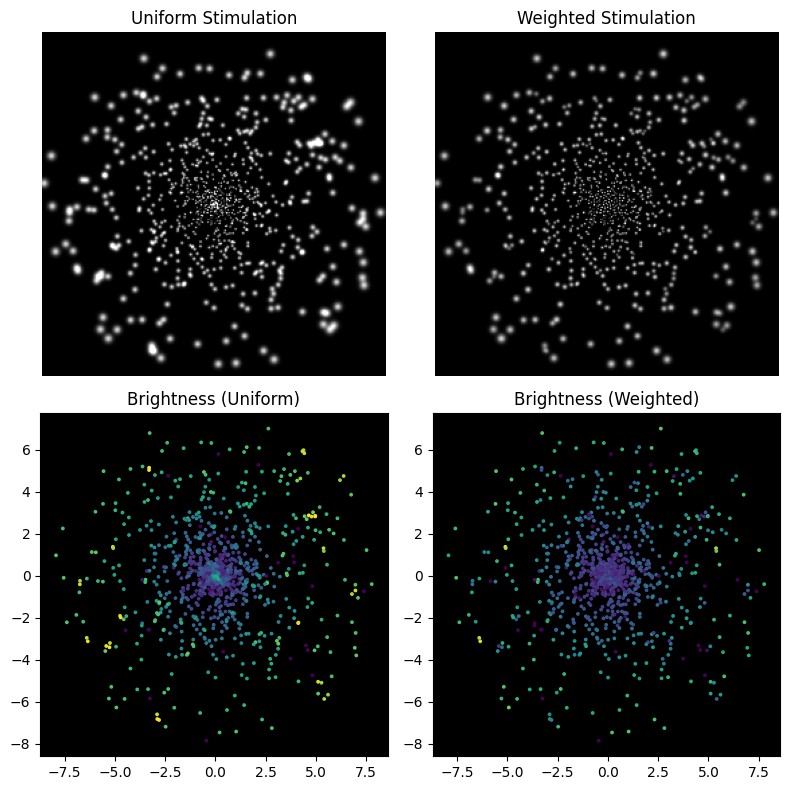

New stimulation: 83.90% of original amplitude


In [7]:
# test stim_weights
simulator.reset()
uniform_stimulation_sequence = torch.ones(n_phosphenes).cuda()*amplitude
phos_uniform = simulator(uniform_stimulation_sequence.cuda())

simulator.reset()
weighted_stimulation_sequence = torch.ones(n_phosphenes).cuda()*amplitude*stim_weights
phos_weighted = simulator(weighted_stimulation_sequence.cuda())

# measure brightness for uniform and weighted stim
brightness_uniform = measure_electrode_brightness_varying(
    phos_uniform, phosphene_coords._x, phosphene_coords._y,
    x_min=-8.0, x_max=8.0,
    y_min=-8.0, y_max=8.0,
    base_size=1,
    scale=0.05,
    center=(0,0)
)

brightness_weighted = measure_electrode_brightness_varying(
    phos_weighted, phosphene_coords._x, phosphene_coords._y,
    x_min=-8.0, x_max=8.0,
    y_min=-8.0, y_max=8.0,
    base_size=1,
    scale=0.05,
    center=(0,0)
)

# Plot the Uniform vs Weighted stimulation and the corresponding brightness in a 2 x 2 plot
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.title("Uniform Stimulation")
plt.imshow(phos_uniform.cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.title("Weighted Stimulation")
plt.imshow(phos_weighted.cpu().numpy(), cmap='gray')
plt.axis('off')

# scatterplot of brightness for uniform vs weighted stim on the phosphene coords
plt.subplot(2,2,3)
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=brightness_uniform, cmap='viridis', s=3)
plt.title("Brightness (Uniform)")
plt.gca().set_facecolor('black')
# plt.axis('off')

plt.subplot(2,2,4)
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=brightness_weighted, cmap='viridis', s=3)
plt.title("Brightness (Weighted)")
plt.gca().set_facecolor('black')
# plt.axis('off')

plt.tight_layout()
plt.show()

# print the mean in percentages of the final weights
print(f"New stimulation: {100*stim_weights.mean():.2f}% of original amplitude")

The results demonstrate that achieving perceived uniformity in brightness significantly enhances the interpretability of the evoked phosphene stimuli. By normalizing brightness across the visual field, overlapping phosphenes and artifacts that obscure the intended stimuli are minimized, making the visual representation clearer and more distinguishable.

Furthermore, the iterative normalization process also results in a decreased total amplitude of stimulation, which has two critical benefits:
1. **Energy Efficiency**: Lower total amplitude reduces the energy consumption of the prosthesis, which is crucial for battery-operated devices.
2. **Safety**: Applying less current to the brain decreases the risk of unintended neural interference or overstimulation, making the device safer for long-term use.

Overall, the perceived uniformity and reduced amplitude provide a compelling approach to optimizing phosphene vision for better patient outcomes and device performance.


## Patterns to convey depth 
A key challenge in phosphene vision is effectively conveying spatial information, such as depth and orientation, to the user. One intuitive approach is the use of patterns, such as a checkerboard floor, to simulate a ground plane or structured reference. This can help patients infer spatial relationships and navigate their environment more effectively.

In [8]:
def checkerboard_generator(bandwidth=32, stim_size=(256,256), dark_value=0.0, light_value=0.5, offset_x=0, offset_y=0):
    """
    Generate a checkerboard pattern
    """
    # Create a checkerboard pattern
    checkerboard = np.zeros(stim_size) + dark_value
    for i in range(stim_size[0]):
        for j in range(stim_size[1]):
            if (i//bandwidth + j//bandwidth) % 2 == 0:
                checkerboard[i,j] = light_value

    # Shift the checkerboard
    checkerboard = np.roll(checkerboard, offset_x, axis=1)
    checkerboard = np.roll(checkerboard, offset_y, axis=0)

    return checkerboard

In [9]:
def warp_image(checkerboard, vanishing_point=(0.4, 0.4), skew=0.0, border=10):
    # Suppose `checkerboard` is your original image, shape [H, W].
    # For demonstration, let's assume it’s a grayscale numpy array.

    # 1) Get the dimensions
    rows, cols = checkerboard.shape[:2]

    # 2) Define the 4 corner points of the original image.
    #    Typically: (top-left, top-right, bottom-left, bottom-right)
    src_points = np.float32([
        [0,       0],
        [cols-1,  0],
        [0,       rows-1],
        [cols-1,  rows-1]
    ])

    # 3) Define where you want these corners to map in the "warped" image.
    #    By moving the top corners closer together, you get a vanishing effect.
    #    For example, push the top-left corner and top-right corner inward 
    #    so they converge. The bottom corners might remain at the full width.

    # Define the vanishing point
    vp_x, vp_y = vanishing_point

    # Define the destination points based on the vanishing point
    dst_points = np.float32([
        [cols*vp_x+skew, rows*vp_y],
        [cols*(1-vp_x)+skew, rows*vp_y],
        [0, rows-1],
        [cols-1, rows-1]
    ])

    # 4) Compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(src_points, dst_points)

    # make the border of the checkerboard white
    checkerboard = cv2.copyMakeBorder(checkerboard, border, border, border, border, cv2.BORDER_CONSTANT, value=1)

    # 5) Apply the transform
    warped = cv2.warpPerspective(checkerboard, M, (cols, rows))
    return warped

In [10]:
def plot_checkerboard(bandwidth=64, dark_value=0.0, light_value=1.0, border=10, vp_x=0.4, vp_y=0.4, skew=0.0, offset_x=0, offset_y=0, weighted=True):
    checkerboard = checkerboard_generator(bandwidth=bandwidth, dark_value=dark_value, light_value=light_value, offset_x=offset_x, offset_y=offset_y)
    warped = warp_image(checkerboard, vanishing_point=(vp_x, vp_y), skew=skew, border=border)
    stim = torch.tensor(warped).float().cuda()
    sample_stim = simulator.sample_stimulus(stim, rescale=True)
    if weighted:
        sample_stim = sample_stim*stim_weights

    simulator.reset()
    phosphenes = simulator(sample_stim)

    plt.figure(figsize=(12,7))

    plt.subplot(1,2,1)
    plt.imshow(stim.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title("Stimulus")

    plt.subplot(1,2,2)
    plt.imshow(phosphenes.cpu(), cmap='gray')
    plt.axis('off')
    plt.title("Phosphene Image")

    plt.show()   

_ = interact(plot_checkerboard, bandwidth=(16, 128, 1), dark_value=(0, 1, 0.01), light_value=(0, 1, 0.01), border=(0, 20, 1),
              vp_x=(0, 0.48, 0.01), vp_y=(0, 0.9, 0.01), skew=(-100, 100, 1), offset_x=(-256, 256, 1), offset_y=(-256, 256, 1), weighted=True)

interactive(children=(IntSlider(value=64, description='bandwidth', max=128, min=16), FloatSlider(value=0.0, de…

## Understanding Spatial Frequency Representation in Phosphene Vision

When visualizing patterns such as the checkerboard, an important question arises: **What spatial frequencies can be represented with a given phosphene layout?** The spatial frequency refers to the level of detail or texture that can be conveyed in a specific region of the visual field. This is a critical aspect of designing effective stimulation patterns for patients relying on prosthetic vision.

### Why is Spatial Frequency Important?

1. **Conveying Detailed Information**  
   Higher spatial frequencies correspond to finer details in the image, such as textures, edges, or small objects. Knowing the maximum frequency representable at a given location helps us determine what level of detail can realistically be conveyed to the user.

2. **Preserving Perceptual Clarity**  
   If the spatial frequency of a stimulus exceeds the maximum frequency supported by the phosphene density, the information may become aliased or distorted, reducing its clarity and utility. Tailoring the patterns to match the phosphene layout ensures that they remain interpretable and meaningful.

3. **Optimizing Information Encoding**  
   Different regions of the visual field have varying phosphene densities due to cortical magnification. Understanding these variations allows us to allocate spatial detail intelligently, emphasizing important regions such as the center (fovea) while simplifying peripheral content.

In the following sections, we will analyze how the phosphene layout determines the maximum spatial frequency that can be represented at different locations in the visual field. This exploration is fundamental for designing stimulation strategies that are not only energy-efficient but also capable of conveying meaningful and interpretable information to the user.


### Nyquist Frequencies for Phosphene Vision

The **Nyquist frequency** defines the highest spatial frequency that can be accurately resolved, based on the spatial arrangement of electrodes. For each electrode \( e \), it is calculated as:

$ f_{\text{Nyquist}, e} = \frac{1}{2d_e} $

where:
- $ d_e $: The average distance from electrode $ e $ to its nearest neighbors.

#### Calculation Steps:
1. **Electrode Layout:** Identify spatial positions of all electrodes.
2. **Neighbor Detection:** Use Delaunay triangulation or Voronoi diagrams to find neighbors.
3. **Average Distance:** Compute:
   $
   d_e = \frac{1}{N} \sum_{i=1}^N d_{i, e}
   $
   where $N$ is the number of neighbors.
4. **Nyquist Frequency:** Calculate:
   $
   f_{\text{Nyquist}, e} = \frac{1}{2d_e}
   $

This frequency map aligns spatial detail with the electrode arrangement, guiding feature extraction methods tailored to the phosphene layout.


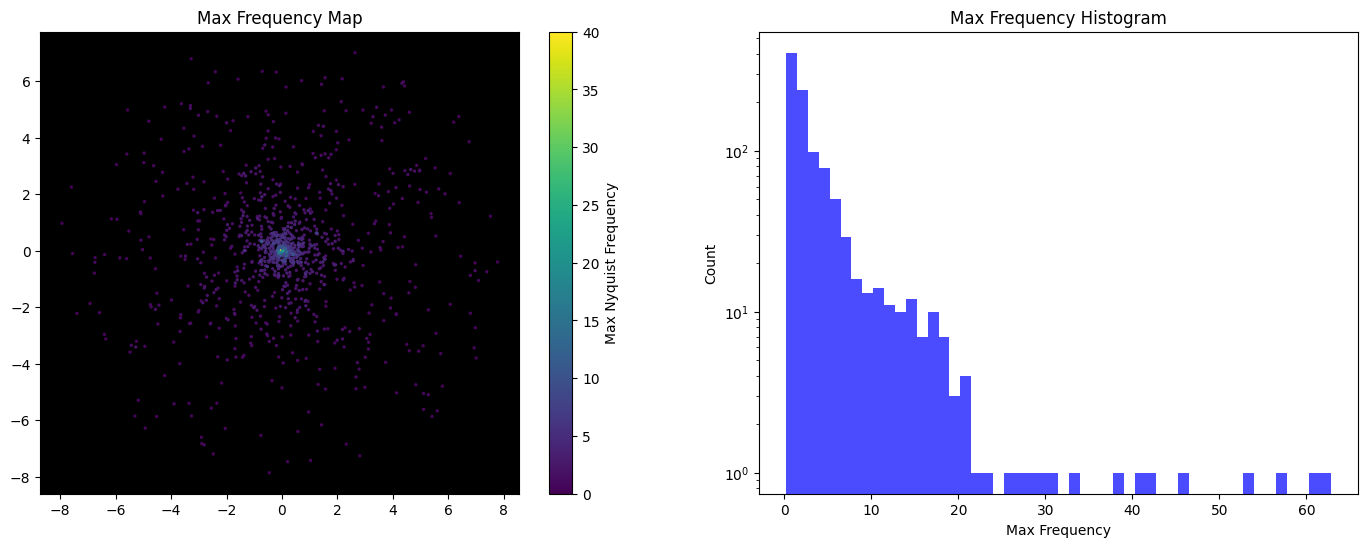

Mean Max Frequency: 3.92
Min Max Frequency (20th percentile): 0.70
Max Max Frequency (97th percentile): 19.99


In [10]:
phos_x = phosphene_coords._x
phos_y = phosphene_coords._y
coords = np.column_stack((phos_x, phos_y))

tri = Delaunay(coords)
neighbors = tri.vertex_neighbor_vertices
avg_distances = []

for i in range(len(coords)):
    start, end = neighbors[0][i], neighbors[0][i+1]
    neighbor_indices = neighbors[1][start:end]
    distances = np.linalg.norm(coords[i] - coords[neighbor_indices], axis=1)
    avg_distances.append(np.mean(distances))

avg_distances = np.array(avg_distances)
max_frequencies = 1 / (2 * avg_distances)  # Nyquist frequency

# show the max frequencies in a scatter plot and in a histogram

plt.figure(figsize=(17,6))

plt.subplot(1,2,1)
# make the max frequencies log scale
plt.scatter(phos_x, -phos_y, c=max_frequencies, cmap='viridis', s=2, vmin=0, vmax=40)
plt.colorbar(label='Max Nyquist Frequency')
plt.title("Max Frequency Map")
plt.gca().set_facecolor('black')

plt.subplot(1,2,2)
plt.hist(max_frequencies, bins=50, color='blue', alpha=0.7)
plt.title("Max Frequency Histogram")
plt.xlabel("Max Frequency")
plt.ylabel("Count")
# log scale
plt.yscale('log')

plt.show()

# take the ... percentile for mean max and min
mean_max_frequency = np.mean(max_frequencies)
min_max_frequency = np.percentile(max_frequencies, 15)
max_max_frequency = np.percentile(max_frequencies, 98)

print(f"Mean Max Frequency: {mean_max_frequency:.2f}")
print(f"Min Max Frequency ({20}th percentile): {min_max_frequency:.2f}")
print(f"Max Max Frequency ({97}th percentile): {max_max_frequency:.2f}")

## Modeling the Maximum Frequency Map

We base our approach on the notion of **cortical magnification**, which posits that the visual field is mapped onto cortex with higher “magnification” (i.e., more cortical territory per degree of visual angle) near the fovea than in the periphery. In our code, we implement this through a **dipole model** of the form

$M(r) = k \left(\frac{1}{r + a} - \frac{1}{r + b}\right),$

where $r$ is the eccentricity in degrees, and $a, b, k$ are model parameters.  

To translate this 1D function $M(r)$ into a *2D phosphene density* $\mathrm{density}(r)$ (i.e., phosphenes per $\text{deg}^2$), we account for the fact that an annulus at radius $r$ has circumference $2\pi r$. Since $M(r)$ alone describes “magnification” radially, we divide by $2\pi r$ to get a proper 2D density. We then apply a **scaling factor** so that when we integrate this density over the entire field of view, the total sums to our desired number of phosphenes (e.g., 1024).

Once we have the *density map* $\mathrm{density}(x, y)$, we estimate the local **Nyquist‐limited maximum spatial frequency** by

$f_{\max}(x, y) = \frac{1}{2}\sqrt{\mathrm{density}(x, y)},$

reflecting that in a random 2D arrangement of points with density $D$, the typical spacing is $1/\sqrt{D}$, and thus the highest resolvable frequency is $1 / (2 \times \text{spacing}) \approx \frac{1}{2}\sqrt{D}$.

---

#### Comparing to Empirical Data

We also measure an **empirical maximum frequency** from our actual phosphene coordinates using a **Delaunay triangulation**: for each electrode, we compute the average distance to its neighbors and invert that distance to get a Nyquist frequency,

$f_{\max,\mathrm{empirical}} = \frac{1}{2\,(\text{avg. neighbor distance})}.$

To visualize this in the field of view, we use a Voronoi diagram based on the phosphene locations, filling each region with its electrode’s empirical max frequency. Finally, we compare the modeled and empirical max‐frequency maps—and their histograms—to see how well our cortical‐magnification‐based model predicts the actual electrode layout.

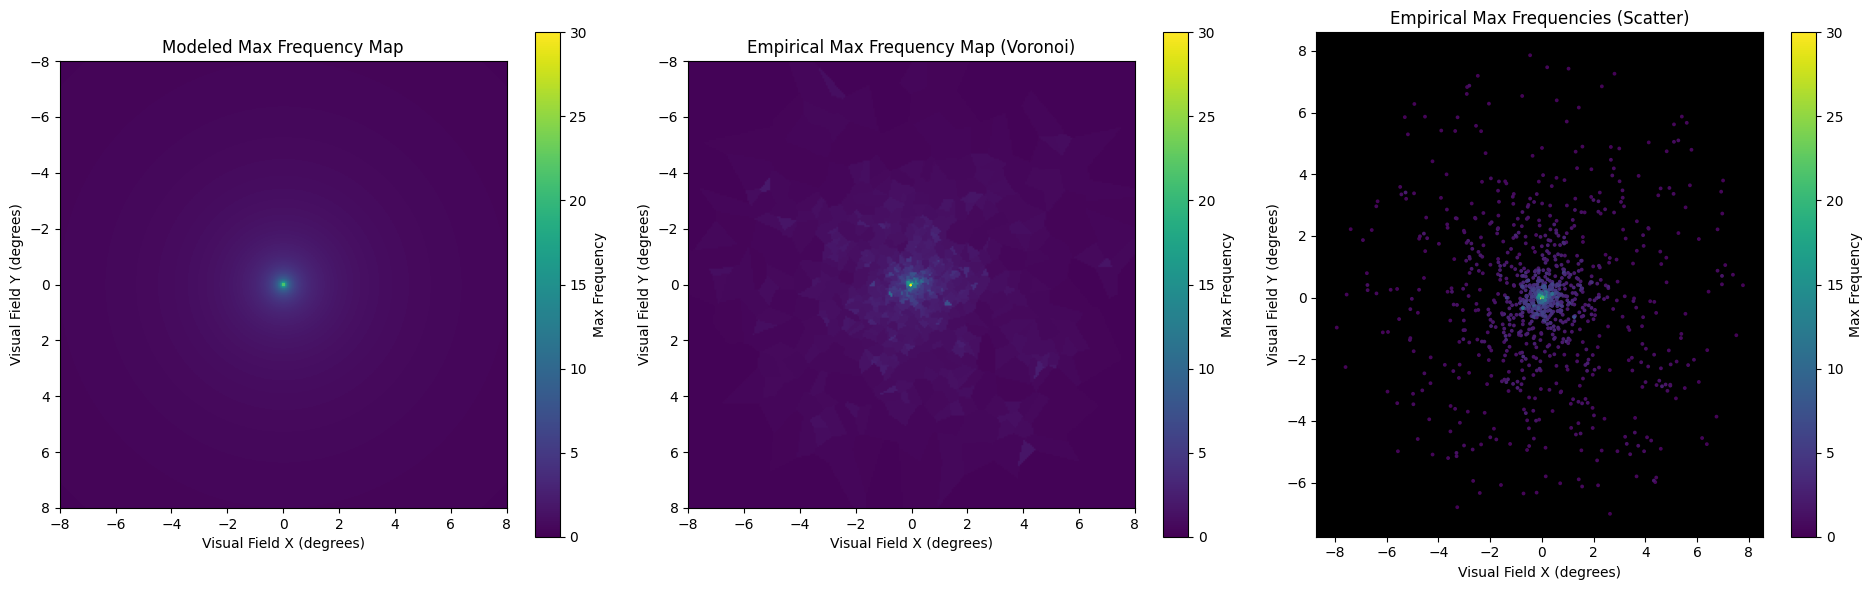

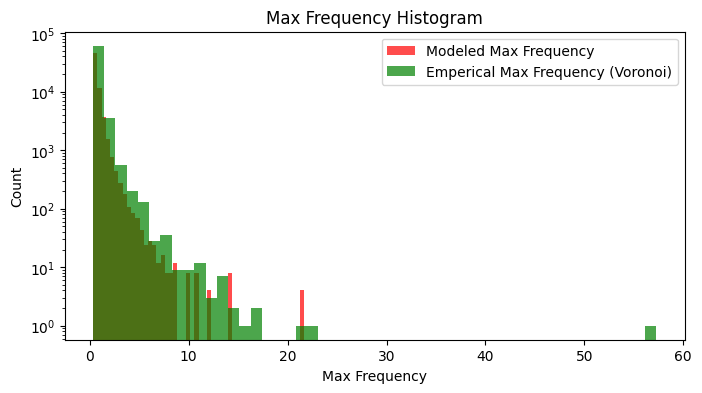

In [11]:
# Define parameters
view_angle = 16  # Visual field angle in degrees
max_eccentricity = view_angle / 2  # Maximum eccentricity in degrees
min_eccentricity = 0.001  # Minimum eccentricity in degrees
total_phosphenes = 1024  # Total number of phosphenes
image_size = 256  # Resolution of the visual field
cortex_model_params = {
    "model": "dipole",
    "k": 17.3,
    "a": 0.75,
    "b": 120
}

# Phosphene coordinates (assumed to be in visual field space)
phos_x = phosphene_coords._x  # Example phosphene x-coordinates
phos_y = phosphene_coords._y  # Example phosphene y-coordinates
coords = np.column_stack((phos_x, phos_y))

# Compute Voronoi diagram
vor = Voronoi(coords)

# Cortical magnification function
def get_cortical_magnification(r, params):
    """Calculate cortical magnification based on eccentricity."""
    model = params["model"]
    a, b, k = params["a"], params["b"], params["k"]
    if model == "monopole":
        return k / (r + a)
    elif model == "dipole":
        return k * (1 / (r + a) - 1 / (r + b))
    else:
        raise ValueError("Unsupported cortical magnification model.")

# Calculate phosphene density map
def calculate_phosphene_density(r, params, total_phosphenes, view_angle, image_size):
    """
    Compute phosphene density map based solely on cortical magnification.
    
    Args:
        r (ndarray): Radial distances (eccentricity) in visual field space.
        params (dict): Cortical magnification model parameters.
        total_phosphenes (int): Total number of phosphenes.
        view_angle (float): Full visual field angle (in degrees).
        image_size (int): Resolution of the visual field space.

    Returns:
        ndarray: Normalized phosphene density map.
    """
    # Step 1: Calculate cortical magnification
    cortical_magnification = get_cortical_magnification(r, params) / (2 * np.pi * r)
    
    # Step 2: Scale the density map to ensure it matches the total number of phosphenes
    scaling_factor = total_phosphenes / (np.sum(cortical_magnification) * (view_angle / image_size) ** 2)
    density_map = cortical_magnification * scaling_factor
    
    # Step 3: Verify the normalization
    density_sum = np.sum(density_map) * (view_angle / image_size) ** 2
    assert np.isclose(density_sum, total_phosphenes, atol=1e-3), \
        f"Density sum mismatch: {density_sum} vs {total_phosphenes}"
    
    return density_map

# Calculate maximum frequency from density
def calculate_max_frequency_with_density(density_map):
    """Calculate the maximum frequency map based on density."""
    return np.sqrt(density_map) / 2 # Nyquist frequency is proportional to sqrt(density)

# Create a 2D grid in visual field space
x = np.linspace(-max_eccentricity, max_eccentricity, image_size)
y = np.linspace(-max_eccentricity, max_eccentricity, image_size)
xx, yy = np.meshgrid(x, y)
r = np.sqrt(xx**2 + yy**2)  # Eccentricity grid

# Compute the modeled phosphene density and max frequency maps
phosphene_density_map = calculate_phosphene_density(r, cortex_model_params, total_phosphenes, view_angle, image_size)
modeled_max_frequency_map = calculate_max_frequency_with_density(phosphene_density_map)

# Empirical max frequencies using Delaunay triangulation
def compute_empirical_max_frequencies(coords):
    """Calculate empirical max frequencies using Delaunay triangulation."""
    from scipy.spatial import Delaunay

    tri = Delaunay(coords)
    neighbors = tri.vertex_neighbor_vertices
    avg_distances = []

    for i in range(len(coords)):
        start, end = neighbors[0][i], neighbors[0][i + 1]
        neighbor_indices = neighbors[1][start:end]
        distances = np.linalg.norm(coords[i] - coords[neighbor_indices], axis=1)
        avg_distances.append(np.mean(distances))

    avg_distances = np.array(avg_distances)
    return 1 / (2 * avg_distances)  # Nyquist frequency

# Compute empirical max frequencies
empirical_max_frequencies = compute_empirical_max_frequencies(coords)

# Generate empirical max frequency map using Voronoi
def compute_voronoi_max_frequency_map(vor, max_frequencies, image_size):
    """Generate a 2D max frequency map from Voronoi regions."""
    max_frequencies_map = np.zeros((image_size, image_size), dtype=np.float32)

    for region_index in range(len(vor.point_region)):
        region = vor.regions[vor.point_region[region_index]]
        if -1 in region or len(region) == 0:
            continue

        polygon = np.array([vor.vertices[v] for v in region])
        mask = np.zeros((image_size, image_size), dtype=np.uint8)
        cv2.fillPoly(mask, [np.int32((polygon + max_eccentricity) / (2 * max_eccentricity) * image_size)], 1)
        max_frequency = max_frequencies[region_index]
        max_frequencies_map[mask == 1] = max_frequency

    return max_frequencies_map 

empirical_max_frequencies_map = compute_voronoi_max_frequency_map(vor, empirical_max_frequencies, image_size)
# for all values that are zero add the minimum frequency that is not 0
min_max_frequency = np.min(empirical_max_frequencies_map[empirical_max_frequencies_map > 0])
empirical_max_frequencies_map[empirical_max_frequencies_map == 0] = min_max_frequency

log10_modeled_max_frequency_map = np.log10(modeled_max_frequency_map)
log10_empirical_max_frequencies_map = np.log10(empirical_max_frequencies_map)
log10_empirical_max_frequencies = np.log10(empirical_max_frequencies)

# Visualization
plt.figure(figsize=(19, 6))

# Modeled max frequency map
plt.subplot(1, 3, 1)
# make the values in log scale
plt.imshow(modeled_max_frequency_map, extent=(-max_eccentricity, max_eccentricity, -max_eccentricity, max_eccentricity),
           cmap='viridis', vmin=0, vmax=30)
plt.colorbar(label="Max Frequency")
plt.title("Modeled Max Frequency Map")
plt.xlabel("Visual Field X (degrees)")
plt.ylabel("Visual Field Y (degrees)")
plt.gca().invert_yaxis()

# Empirical max frequency map
plt.subplot(1, 3, 2)
plt.imshow(empirical_max_frequencies_map, extent=(-max_eccentricity, max_eccentricity, -max_eccentricity, max_eccentricity),
           cmap='viridis', vmin=0, vmax=30)
plt.colorbar(label="Max Frequency")
plt.title("Empirical Max Frequency Map (Voronoi)")
plt.xlabel("Visual Field X (degrees)")
plt.ylabel("Visual Field Y (degrees)")
plt.gca().invert_yaxis()

# Scatter plot of phosphene max frequencies
plt.subplot(1, 3, 3)
plt.scatter(phos_x, phos_y, c=empirical_max_frequencies,
             cmap='viridis', s=3, vmin=0, vmax=30)
plt.colorbar(label="Max Frequency")
plt.title("Empirical Max Frequencies (Scatter)")
plt.xlabel("Visual Field X (degrees)")
plt.ylabel("Visual Field Y (degrees)")
plt.gca().set_facecolor("black")

plt.tight_layout()
plt.show()

# histograms of the modeled and emperical max frequencies
plt.figure(figsize=(8, 4))

plt.hist(modeled_max_frequency_map.flatten(), bins=50, color='red', alpha=0.7, label='Modeled Max Frequency')
plt.hist(empirical_max_frequencies_map.flatten(), bins=50, color='green', alpha=0.7, label='Emperical Max Frequency (Voronoi)')
# plt.hist(log10_empirical_max_frequencies.flatten(), bins=100, color='blue', alpha=0.4, label='Emperical Max Frequency (phosphenes)')
plt.title("Max Frequency Histogram")
plt.xlabel("Max Frequency")
plt.ylabel("Count")
plt.yscale('log')
plt.legend()

plt.show()

### Demonstration: Frequency Values at Specific Angles

This demonstration extracts maximum spatial frequencies at specific angles in the visual field using the modeled max frequency map. Angles are converted to Cartesian coordinates, and the corresponding frequency values are retrieved from the map. This showcases how spatial resolution varies with direction and eccentricity.


Frequency values at angles [0.2, 1.5, 7] degrees: [8.749443477399174, 2.1543944218888624, 0.5322562134667959]


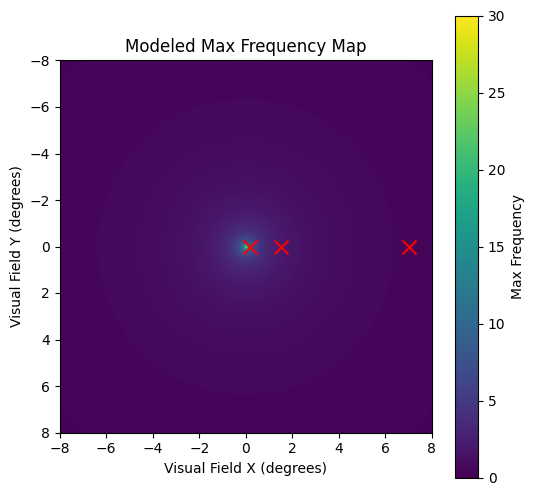

In [12]:
angles = [0.2, 1.5, 7]
freq_values = []

for angle in angles:
    x = angle
    y = 0
    r = np.sqrt(x**2 + y**2)
    x_idx = int((x + max_eccentricity) / (2 * max_eccentricity) * image_size)
    y_idx = int((y + max_eccentricity) / (2 * max_eccentricity) * image_size)
    freq_values.append(modeled_max_frequency_map[y_idx, x_idx])

print(f"Frequency values at angles {angles} degrees: {freq_values}")

# point out the angles on the max frequency map
plt.figure(figsize=(6,6))
plt.imshow(modeled_max_frequency_map, extent=(-max_eccentricity, max_eccentricity, -max_eccentricity, max_eccentricity),
           cmap='viridis', vmin=0, vmax=30)
plt.colorbar(label="Max Frequency")
plt.title("Modeled Max Frequency Map")
plt.xlabel("Visual Field X (degrees)")
plt.ylabel("Visual Field Y (degrees)")
plt.gca().invert_yaxis()

for angle in angles:
    plt.scatter(angle, 0, c='red', s=100, marker='x')

plt.show()

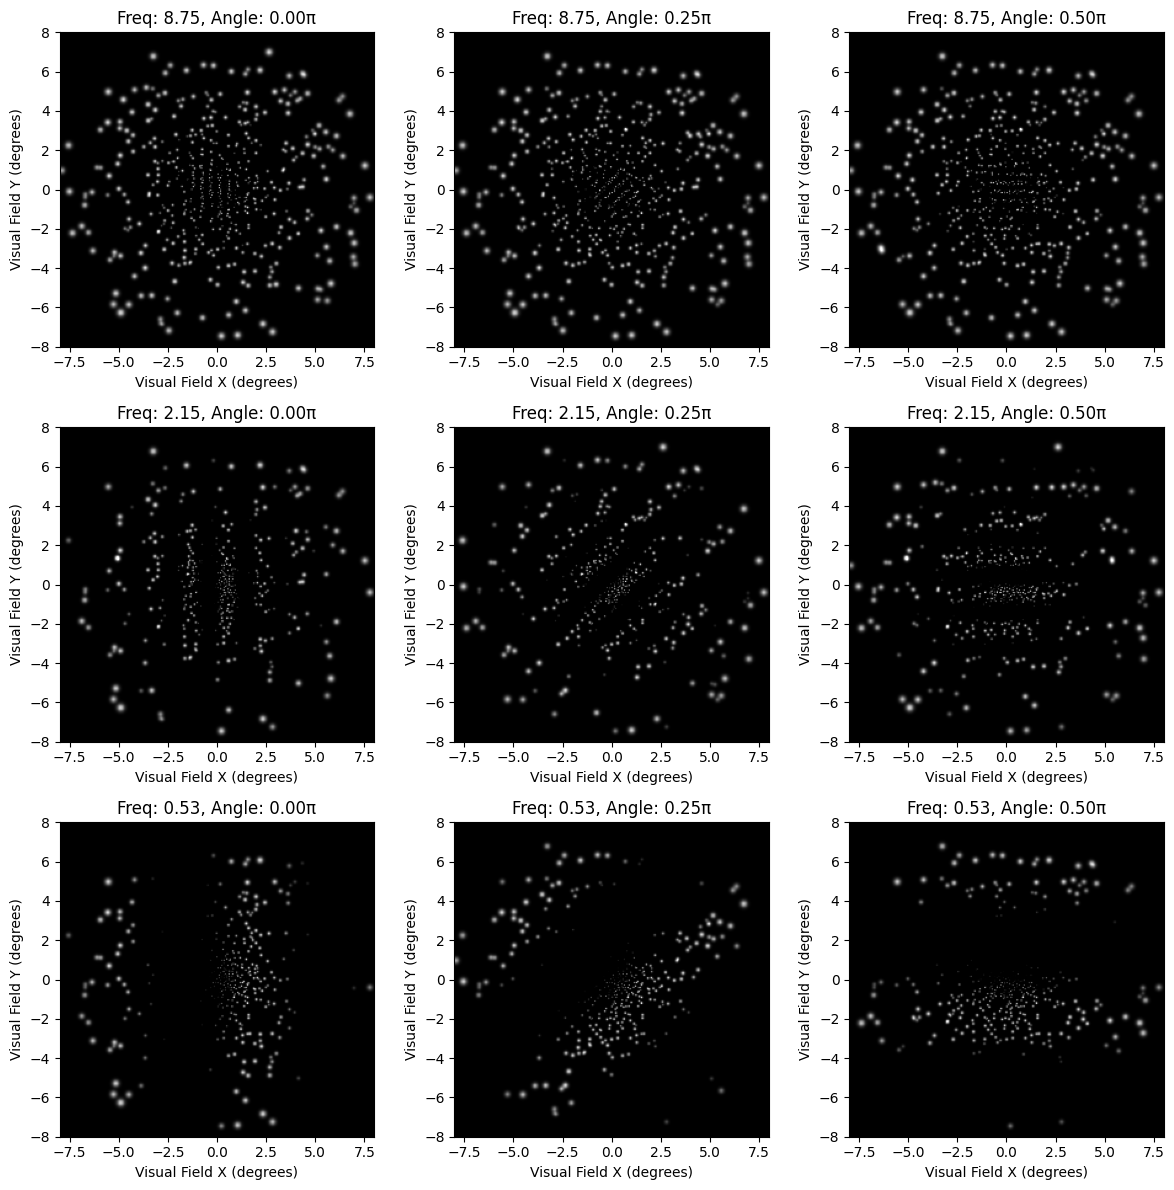

In [13]:
def generate_sinusoidal_pattern(size, freq, angle):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    wave = np.sin(4 * np.pi * freq * (X * np.cos(angle) + Y * np.sin(angle)))
    return (wave + 1) / 2  # Normalize to [0, 1]

# given the min_max_frequency, mean_max_frequency and max_max_frequency generate the sinusoidal pattern for a couple of angles and the phosphene image and show side by side

frequencies = freq_values
angles = [0, np.pi/4, np.pi/2]
size = 256
patterns = []

for freq in frequencies:
    for angle in angles:
        pattern = generate_sinusoidal_pattern(size, freq, angle)
        patterns.append(pattern)

phosphene_images = []
for pattern in patterns:
    stimulus = torch.tensor(pattern).float().cuda()
    simulator.reset()
    phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*stim_weights)
    phosphene_images.append(phosphenes)

# show all phosphene images
plt.figure(figsize=(12,12))

for i, phos_image in enumerate(phosphene_images):
    plt.subplot(3,3,i+1)
    plt.imshow(phos_image.cpu().numpy(), cmap='gray', extent=(-max_eccentricity, max_eccentricity, -max_eccentricity, max_eccentricity))
    plt.xlabel("Visual Field X (degrees)")
    plt.ylabel("Visual Field Y (degrees)")

    plt.title(f"Freq: {frequencies[i//3]:.2f}, Angle: {angles[i%3]/np.pi:.2f}π")

plt.tight_layout()
plt.show()

In [14]:
# interactive plot for the sinusoidal patterns
def plot_sinusoidal_pattern(freq=1, angle=0):
    pattern = generate_sinusoidal_pattern(size, freq, angle)
    stimulus = torch.tensor(pattern).float().cuda()
    simulator.reset()
    phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*stim_weights)

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(pattern, cmap='gray')
    plt.title("Sinusoidal Pattern")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(phosphenes.cpu().numpy(), cmap='gray', extent=(-max_eccentricity, max_eccentricity, -max_eccentricity, max_eccentricity))
    plt.title(f"Phosphene Image (Freq: {freq:.2f}, Angle: {angle/np.pi:.2f}π)")
    plt.axis('off')

    plt.show()

_ = interact(plot_sinusoidal_pattern, freq=(0, 12, 0.01), angle=(0, np.pi, 0.01))

interactive(children=(FloatSlider(value=1.0, description='freq', max=12.0, step=0.01), FloatSlider(value=0.0, …

# Multi frequency response

## Demonstration of Laplacian of Gaussian at different Frequencies

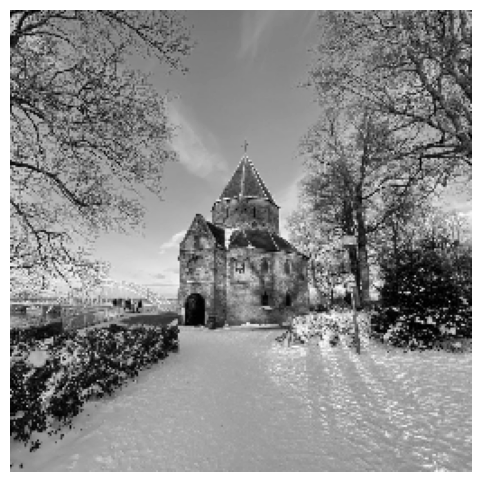

In [16]:
# open image valkhof.jpg

# Load the image
data_folder = '../data/'
image = cv2.imread(os.path.join(data_folder, 'example_images', 'valkhof.jpg'), cv2.IMREAD_GRAYSCALE)
# crop image to be square
# get the dimensions
h, w = image.shape
# calculate the crop size
crop_size = min(h, w)
# calculate the starting point
start_x = (w - crop_size) // 2
start_y = (h - crop_size) // 2
# crop the image
image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]
image = cv2.resize(image, (256, 256))/255

# show the image
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [17]:
def laplacian_of_gaussian_fov(image, target_frequency=1.0, fov=16, image_size=256):
    """
    Apply a Laplacian of Gaussian (LoG) filter to an image, with frequency defined in field-of-view space.

    Parameters:
        image (ndarray): Input image (grayscale).
        kernel_size (int): Size of the Gaussian kernel (odd number).
        target_frequency (float): Frequency in cycles per degree to detect.
        fov (float): Total field of view in degrees.
        image_size (int): Size of the image in pixels (assumes square image).

    Returns:
        ndarray: Image filtered with the LoG filter.
    """
    # Calculate sigma in field-of-view space for the target frequency
    # The relationship is sigma = 1 / (2 * pi * target_frequency)
    sigma_fov = 1 / (2 * np.pi * target_frequency)

    # Convert sigma from field-of-view space to pixel space
    sigma_pixels = 2 * sigma_fov * (image_size / fov)

    # Calculate kernel size (odd number)
    kernel_size = int(4 * sigma_pixels + 1)
    if kernel_size % 2 == 0:
        kernel_size += 1

    # Create Laplacian of Gaussian kernel
    y, x = np.meshgrid(np.arange(-kernel_size//2 + 1, kernel_size//2 + 1),
                       np.arange(-kernel_size//2 + 1, kernel_size//2 + 1))
    laplacian = -(1/(np.pi * sigma_pixels**4)) * (1 - (x**2 + y**2) / (2 * sigma_pixels**2)) * \
                np.exp(-(x**2 + y**2) / (2 * sigma_pixels**2))
    
    # Normalize the LoG kernel
    laplacian -= laplacian.mean()

    # Apply the LoG filter
    filtered_image = cv2.filter2D(image, -1, laplacian)
    return filtered_image


In [18]:
# interactive plot for the laplacian_of_gaussian_fov filter: target_frequency, fov

def plot_laplacian_of_gaussian_fov(target_frequency=8.0, freq_divider=3):
    filtered_image = laplacian_of_gaussian_fov(image, target_frequency=target_frequency/freq_divider, fov=16, image_size=256)
    filtered_image = np.clip(filtered_image, 0, None)
    filtered_image = (filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min())
    filtered_image = filtered_image * 2

    stimulus = torch.tensor(filtered_image).float().cuda()
    simulator.reset()
    phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*stim_weights)

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(filtered_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Filtered Image (Freq: {target_frequency:.2f})")

    plt.subplot(1,2,2)
    plt.imshow(phosphenes.cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title("Phosphene Image")

    plt.show()

_ = interact(plot_laplacian_of_gaussian_fov, target_frequency=(0.1, 16, 0.01), freq_divider=(1, 10, 1))

interactive(children=(FloatSlider(value=8.0, description='target_frequency', max=16.0, min=0.1, step=0.01), In…

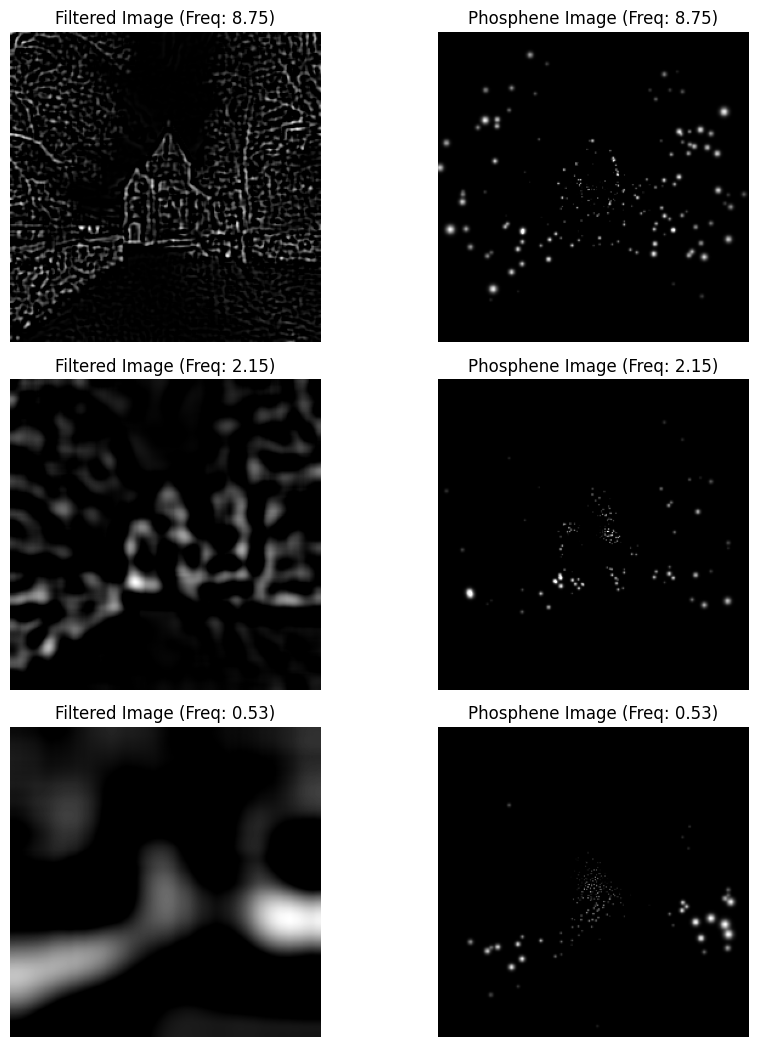

In [19]:
# Apply LoG filters with different parameters
target_frequencies = frequencies
filtered_images = []

for target_frequency in target_frequencies:
    target_frequency = target_frequency / 3
    filtered_image = laplacian_of_gaussian_fov(image, target_frequency=target_frequency, fov=16, image_size=256)
    filtered_image = np.clip(filtered_image, 0, None)
    filtered_image = (filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min())
    # filtered_image = np.abs(filtered_image)
    filtered_images.append(filtered_image * 2)

# show the phosphenes for the filtered images
phosphene_images = []
for pattern in filtered_images:
    stimulus = torch.tensor(pattern).float().cuda()
    simulator.reset()
    phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*stim_weights)
    phosphene_images.append(phosphenes)

# show together the filtered images and the phosphenes
plt.figure(figsize=(13,21))

for i, (filtered_image, phos_image) in enumerate(zip(filtered_images, phosphene_images)):
    plt.subplot(6,3,3*i+1)
    plt.imshow(filtered_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Filtered Image (Freq: {target_frequencies[i]:.2f})")

    plt.subplot(6,3,3*i+2)
    plt.imshow(phos_image.cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f"Phosphene Image (Freq: {target_frequencies[i]:.2f})")
    
plt.tight_layout()
plt.show()

# Fov Conv2D LoG Module

In [20]:
from components.fov_conv2d_cont import FovConv2dCont

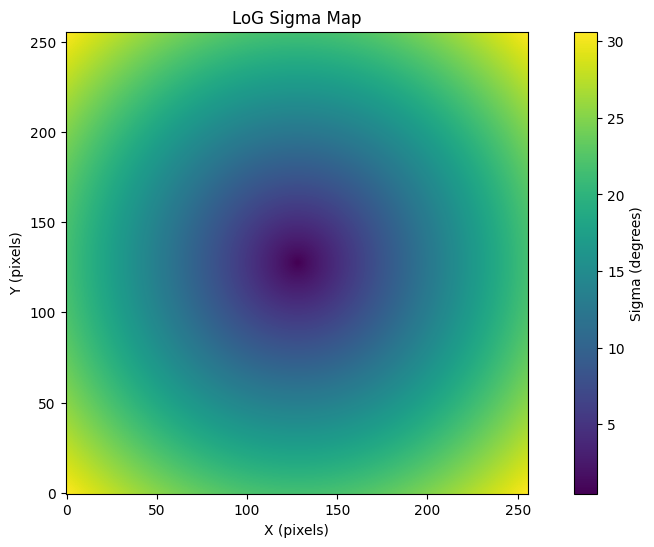

In [21]:
# 1) compute 2D density from your cortical magnification 
#    (via get_cortical_magnification(r)/(2pi*r) etc.) => density_map (phosphenes/deg^2)
# Create a 2D grid in visual field space
x = np.linspace(-max_eccentricity, max_eccentricity, image_size)
y = np.linspace(-max_eccentricity, max_eccentricity, image_size)
xx, yy = np.meshgrid(x, y)
r = np.sqrt(xx**2 + yy**2)  # Eccentricity grid

density_map = calculate_phosphene_density(r, cortex_model_params, total_phosphenes, view_angle, image_size)

# 2) local Nyquist frequency
fmax_map = 0.5 * np.sqrt(density_map)  # cyc/deg

# 3) LoG sigma in degrees
sigma_fov_map = 1.0 / (2.0 * np.pi * fmax_map)  # or 1/(pi * sqrt(density_map))

# 4) convert to pixels
fov = 16
sigma_map_px = sigma_fov_map * (N / fov)


# plot sigma_fov_map
plt.figure(figsize=(12, 6))

plt.imshow(sigma_map_px, cmap='viridis')
plt.colorbar(label='Sigma (degrees)')
plt.title('LoG Sigma Map')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.gca().invert_yaxis()

plt.show()

In [22]:
sigma_map_tensor = torch.Tensor(sigma_map_px).float().cuda().unsqueeze(0).unsqueeze(0)
in_channels = 1
out_channels = 1
kernel_size = 1
net = FovConv2dCont(in_channels, out_channels, kernel_size, kernel_type='LoG', sigma_map=sigma_map_tensor,
                    log_kernel_size=99, sigma_function='map', padding_mode='reflect').cuda()

foa_xy = torch.tensor([128, 128]).float().cuda().unsqueeze(0)

/gpfs/home1/mappel/Dynaphos/spatial_frequency/notebooks/./../components/fov_conv2d_cont.py:298: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma_map = torch.tensor(sigma_map, dtype=torch.float32)


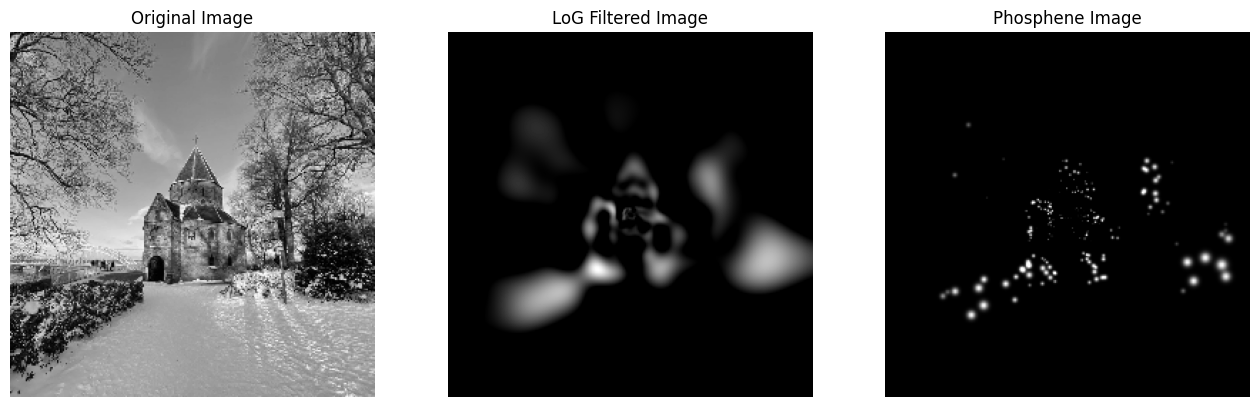

In [23]:
# Load the image
data_folder = '../data/'
image = cv2.imread(os.path.join(data_folder, 'example_images', 'valkhof.jpg'), cv2.IMREAD_GRAYSCALE)
h, w = image.shape
crop_size = min(h, w)

start_x = (w - crop_size) // 2
start_y = (h - crop_size) // 2
image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]
image = cv2.resize(image, (256, 256))/255

# center of the image foa_xy

torch_image = torch.tensor(image).unsqueeze(0).float().cuda().unsqueeze(0)
out = net(torch_image, foa_xy)

# show out
out_image = out[0][0].detach().cpu().numpy()
out_image = out_image.clip(0, None)
out_image = (out_image - out_image.min()) / (out_image.max() - out_image.min())

stimulus = torch.tensor(out_image).float().cuda()
simulator.reset()
phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*3*stim_weights) 

# show out_image and phosphenes
plt.figure(figsize=(16,7))

plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(out_image, cmap='gray')
plt.axis('off')
plt.title("LoG Filtered Image")

plt.subplot(1,3,3)
plt.imshow(phosphenes.cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title("Phosphene Image")

plt.show()

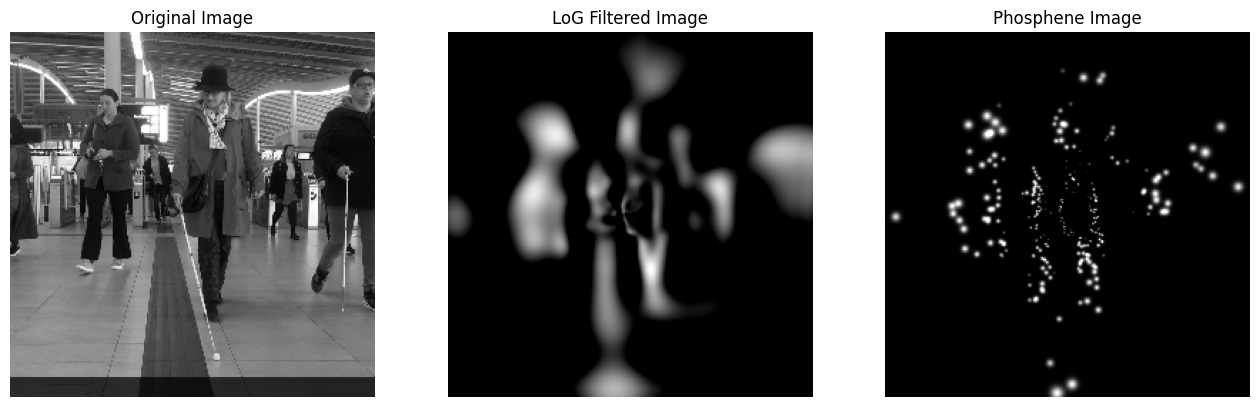

In [24]:
# Load the image
data_folder = '../data/'
image = cv2.imread(os.path.join(data_folder, 'example_images', 'station.png'), cv2.IMREAD_GRAYSCALE)
h, w = image.shape
crop_size = min(h, w)

start_x = (w - crop_size) // 2
start_y = (h - crop_size) // 2
image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]
image = cv2.resize(image, (256, 256))/255

# center of the image foa_xy

torch_image = torch.tensor(image).unsqueeze(0).float().cuda().unsqueeze(0)
out = net(torch_image, foa_xy)

# show out
out_image = out[0][0].detach().cpu().numpy()
out_image = out_image.clip(0, None)
out_image = (out_image - out_image.min()) / (out_image.max() - out_image.min())

stimulus = torch.tensor(out_image).float().cuda()
simulator.reset()
phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*3*stim_weights) 

# show out_image and phosphenes
plt.figure(figsize=(16,7))

plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(out_image, cmap='gray')
plt.axis('off')
plt.title("LoG Filtered Image")

plt.subplot(1,3,3)
plt.imshow(phosphenes.cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title("Phosphene Image")

plt.show()

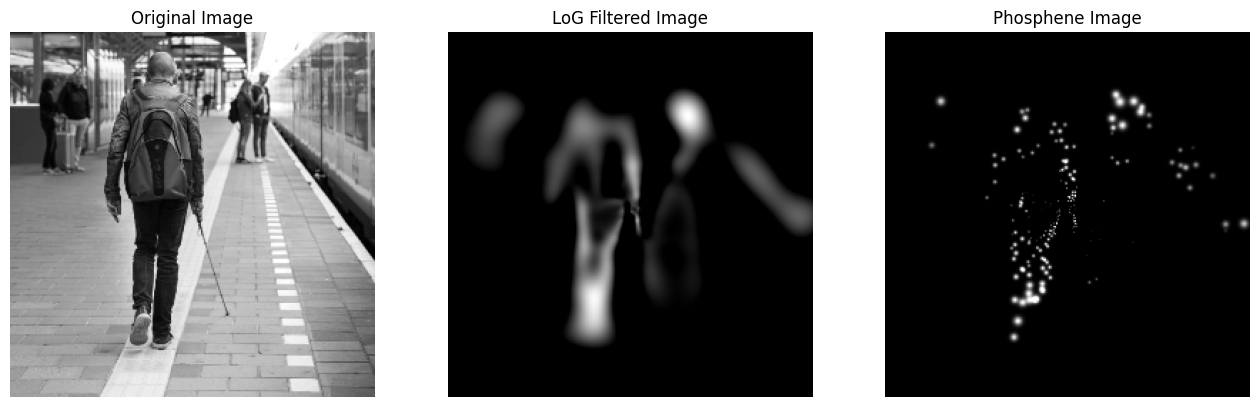

In [25]:
data_folder = '../data/'
image = cv2.imread(os.path.join(data_folder, 'example_images', 'station2.jpg'), cv2.IMREAD_GRAYSCALE)
h, w = image.shape
crop_size = min(h, w)

start_x = (w - crop_size) // 2
start_y = (h - crop_size) // 2
image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]
image = cv2.resize(image, (256, 256))/255

# center of the image foa_xy

torch_image = torch.tensor(image).unsqueeze(0).float().cuda().unsqueeze(0)
out = net(torch_image, foa_xy)

# show out
out_image = out[0][0].detach().cpu().numpy()
out_image = out_image.clip(0, None)
out_image = (out_image - out_image.min()) / (out_image.max() - out_image.min())

stimulus = torch.tensor(out_image).float().cuda()
simulator.reset()
phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*3*stim_weights) 

# show out_image and phosphenes
plt.figure(figsize=(16,7))

plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(out_image, cmap='gray')
plt.axis('off')
plt.title("LoG Filtered Image")

plt.subplot(1,3,3)
plt.imshow(phosphenes.cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title("Phosphene Image")

plt.show()

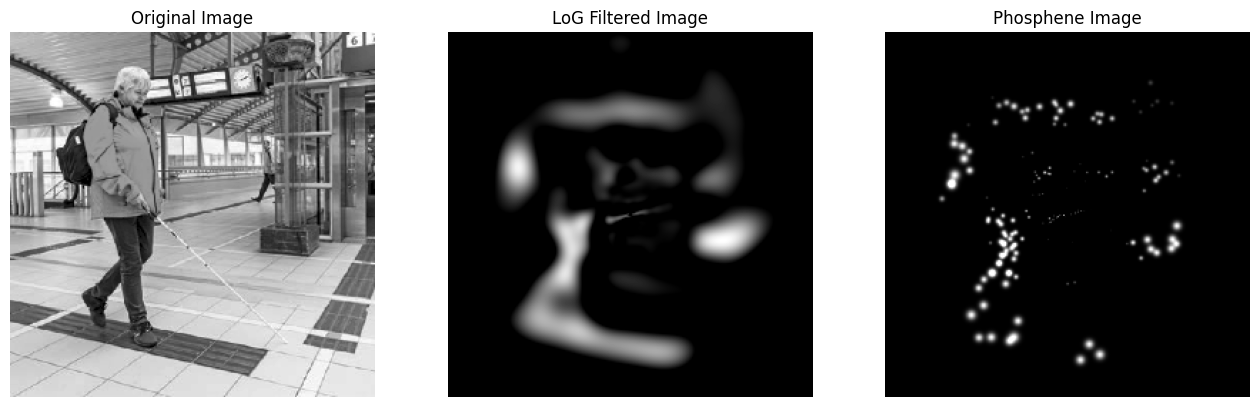

In [26]:
data_folder = '../data/'
image = cv2.imread(os.path.join(data_folder, 'example_images', 'station3.png'), cv2.IMREAD_GRAYSCALE)
h, w = image.shape
crop_size = min(h, w)

start_x = (w - crop_size) // 2
start_y = (h - crop_size) // 2
image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]
image = cv2.resize(image, (256, 256))/255

# center of the image foa_xy

torch_image = torch.tensor(image).unsqueeze(0).float().cuda().unsqueeze(0)
out = net(torch_image, foa_xy)

# show out
out_image = out[0][0].detach().cpu().numpy()
out_image = out_image.clip(0, None)
out_image = (out_image - out_image.min()) / (out_image.max() - out_image.min())

stimulus = torch.tensor(out_image).float().cuda()
simulator.reset()
phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*3*stim_weights) 

# show out_image and phosphenes
plt.figure(figsize=(16,7))

plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(out_image, cmap='gray')
plt.axis('off')
plt.title("LoG Filtered Image")

plt.subplot(1,3,3)
plt.imshow(phosphenes.cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title("Phosphene Image")

plt.show()

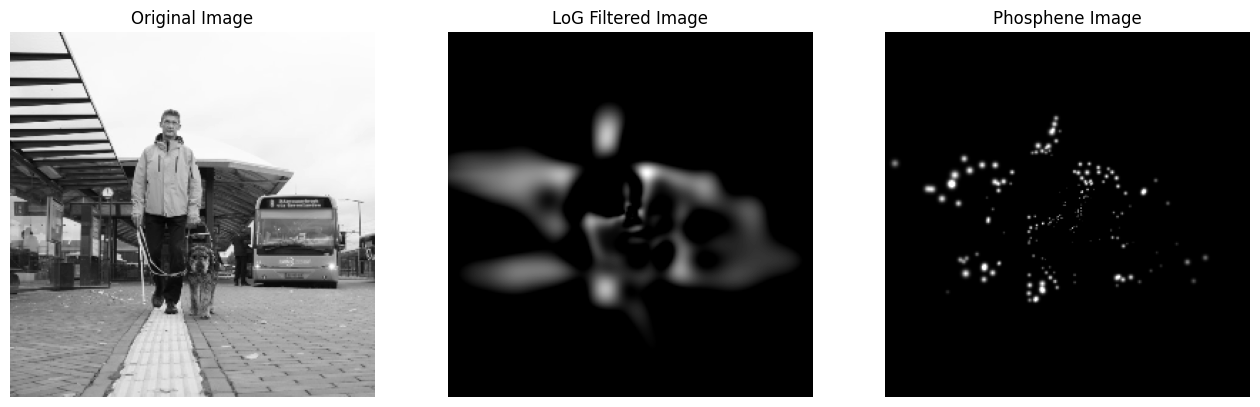

In [27]:
data_folder = '../data/'
image = cv2.imread(os.path.join(data_folder, 'example_images', 'station4.jpg'), cv2.IMREAD_GRAYSCALE)
h, w = image.shape
crop_size = min(h, w)

start_x = 0
start_y = (h - crop_size) // 2
image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]
image = cv2.resize(image, (256, 256))/255

# center of the image foa_xy

torch_image = torch.tensor(image).unsqueeze(0).float().cuda().unsqueeze(0)
out = net(torch_image, foa_xy)

# show out
out_image = out[0][0].detach().cpu().numpy()
out_image = out_image.clip(0, None)
out_image = (out_image - out_image.min()) / (out_image.max() - out_image.min())

stimulus = torch.tensor(out_image).float().cuda()
simulator.reset()
phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*3*stim_weights) 

# show out_image and phosphenes
plt.figure(figsize=(16,7))

plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(out_image, cmap='gray')
plt.axis('off')
plt.title("LoG Filtered Image")

plt.subplot(1,3,3)
plt.imshow(phosphenes.cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title("Phosphene Image")

plt.show()

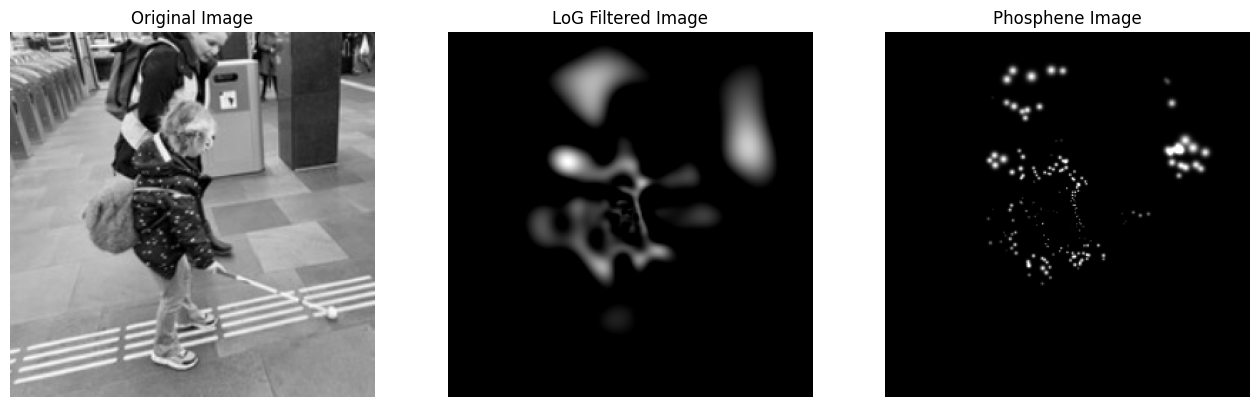

In [28]:
data_folder = '../data/'
image = cv2.imread(os.path.join(data_folder, 'example_images', 'station5.jpg'), cv2.IMREAD_GRAYSCALE)
h, w = image.shape
crop_size = min(h, w)

start_x = 0
start_y = (h - crop_size) // 2
image = image[start_y:start_y+crop_size, start_x:start_x+crop_size]
image = cv2.resize(image, (256, 256))/255

# center of the image foa_xy

torch_image = torch.tensor(image).unsqueeze(0).float().cuda().unsqueeze(0)
out = net(torch_image, foa_xy)

# show out
out_image = out[0][0].detach().cpu().numpy()
out_image = out_image.clip(0, None)
out_image = (out_image - out_image.min()) / (out_image.max() - out_image.min())

stimulus = torch.tensor(out_image).float().cuda()
simulator.reset()
phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*3*stim_weights) 

# show out_image and phosphenes
plt.figure(figsize=(16,7))

plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(out_image, cmap='gray')
plt.axis('off')
plt.title("LoG Filtered Image")

plt.subplot(1,3,3)
plt.imshow(phosphenes.cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title("Phosphene Image")

plt.show()

In [29]:
# framerate = params['run']['fps'] 
# max_n_frames = 30*framerate
# data_folder = '../data/'

# cap = cv2.VideoCapture(os.path.join(data_folder, 'example_videos', 'PastaSalad.mp4'))
# # crop from 1 minute to 1:30
# cap.set(cv2.CAP_PROP_POS_MSEC, 60*1000)
# # print length of video
# length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# print( length, 'frames')

# if not cap.isOpened():
#     print('Unable to read file :(')

# # Set the output stream
# fourcc = cv2.VideoWriter_fourcc(*'XVID') #codec
# out = cv2.VideoWriter('pasta_salad_phosphenes.mp4', fourcc, framerate, (3*256,256),False)

# # Loop over frames
# frame_nr = 0
# while frame_nr<max_n_frames:
#     # load next frame
#     ret, frame = cap.read()
#     frame_nr+=1
    
#     if not ret:
#         break 
        
#     # to one channel, grayscale 
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # get square if frame is not square
#     if frame.shape[0] != frame.shape[1]:
#         shortest_side = min(frame.shape)
#         frame = frame[frame.shape[0]//2-shortest_side//2:frame.shape[0]//2+shortest_side//2,
#                       frame.shape[1]//2-shortest_side//2:frame.shape[1]//2+shortest_side//2]
        
#     # preprocess: to resize, grayscale and blur
#     frame = cv2.resize(frame, (256,256))

#     torch_image = torch.tensor(frame).unsqueeze(0).float().cuda().unsqueeze(0)
#     net_out = net(torch_image, foa_xy)

#     # show out
#     out_image = net_out[0][0].detach().cpu().numpy()
#     out_image = out_image.clip(0, None)
#     out_image = (out_image - out_image.min()) / (out_image.max() - out_image.min())*255

#     stimulus = simulator.sample_stimulus(out_image, rescale=True)*3*stim_weights
#     simulator.reset()
#     # Generate phosphenes 
#     phs = simulator(stimulus).clamp(0,1)
#     phs = to_numpy(phs)*255

#     cat = np.concatenate([frame, out_image, phs], axis=1).astype('uint8')
    
#     out.write(cat)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# out.release() 

# cv2.destroyAllWindows()